<a href="https://colab.research.google.com/github/neil1011/spam_email/blob/main/spam_email.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [41]:
import pandas as pd
import re
import string
import numpy as np
from sklearn.feature_extraction import _stop_words

In [43]:
data = pd.read_csv("/content/spam.csv")

In [44]:
data

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [47]:
from sklearn.model_selection import train_test_split
emails_train, emails_test, target_train, target_test = train_test_split(data.Message,data.Category,test_size = 0.2)

In [48]:
data.info

<bound method DataFrame.info of      Category                                            Message
0         ham  Go until jurong point, crazy.. Available only ...
1         ham                      Ok lar... Joking wif u oni...
2        spam  Free entry in 2 a wkly comp to win FA Cup fina...
3         ham  U dun say so early hor... U c already then say...
4         ham  Nah I don't think he goes to usf, he lives aro...
...       ...                                                ...
5567     spam  This is the 2nd time we have tried 2 contact u...
5568      ham               Will ü b going to esplanade fr home?
5569      ham  Pity, * was in mood for that. So...any other s...
5570      ham  The guy did some bitching but I acted like i'd...
5571      ham                         Rofl. Its true to its name

[5572 rows x 2 columns]>

In [49]:
emails_train.shape

(4457,)

In [50]:
def remove_hyperlink(word):
    return  re.sub(r"http\S+", "", word)

def to_lower(word):
    result = word.lower()
    return result

def remove_number(word):
    result = re.sub(r'\d+', '', word)
    return result

def remove_punctuation(word):
    result = word.translate(str.maketrans(dict.fromkeys(string.punctuation)))
    return result

def remove_whitespace(word):
    result = word.strip()
    return result

def replace_newline(word):
    return word.replace('\n','')



def clean_up_pipeline(sentence):
    cleaning_utils = [remove_hyperlink,
                      replace_newline,
                      to_lower,
                      remove_number,
                      remove_punctuation,remove_whitespace]
    for o in cleaning_utils:
        sentence = o(sentence)
    return sentence

x_train = [clean_up_pipeline(o) for o in emails_train]
x_test = [clean_up_pipeline(o) for o in emails_test]

x_train[0]

'no got new job at bar in airport on satsgettin per hour but means no lie in keep in touch'

In [51]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
train_y = le.fit_transform(target_train.values)
test_y = le.transform(target_test.values)

In [52]:
train_y

array([0, 0, 0, ..., 0, 0, 0])

In [53]:
## some config values
embed_size = 100 # how big is each word vector
max_feature = 50000 # how many unique words to use (i.e num rows in embedding vector)
max_len = 2000 # max number of words in a question to use
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=max_feature)

tokenizer.fit_on_texts(x_train)

x_train_features = np.array(tokenizer.texts_to_sequences(x_train))
x_test_features = np.array(tokenizer.texts_to_sequences(x_test))

x_train_features[0]

[37,
 59,
 97,
 274,
 28,
 3504,
 8,
 1331,
 18,
 3505,
 212,
 338,
 24,
 388,
 37,
 1528,
 8,
 178,
 8,
 625]

In [54]:
from keras.preprocessing.sequence import pad_sequences
x_train_features = pad_sequences(x_train_features,maxlen=max_len)
x_test_features = pad_sequences(x_test_features,maxlen=max_len)
x_train_features[0]

array([  0,   0,   0, ..., 178,   8, 625], dtype=int32)

In [55]:
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional
from keras.models import Model

In [56]:
# create the model
import tensorflow as tf
embedding_vecor_length = 32

model = tf.keras.Sequential()
model.add(Embedding(max_feature, embedding_vecor_length, input_length=max_len))
model.add(Bidirectional(tf.keras.layers.LSTM(64)))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 2000, 32)          1600000   
                                                                 
 bidirectional (Bidirection  (None, 128)               49664     
 al)                                                             
                                                                 
 dense (Dense)               (None, 16)                2064      
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 1651745 (6.30 MB)
Trainable params: 1651745 (6.30 MB)
Non-trainable params: 0 (0.00 Byte)
__________________

In [57]:
history = model.fit(x_train_features, train_y, batch_size=512, epochs=20, validation_data=(x_test_features, test_y))

Epoch 1/20
9/9 [==============================] - 147s 16s/step - loss: 0.6346 - accuracy: 0.8643 - val_loss: 0.5187 - val_accuracy: 0.8583
Epoch 2/20
9/9 [==============================] - 135s 15s/step - loss: 0.4268 - accuracy: 0.8678 - val_loss: 0.3991 - val_accuracy: 0.8583
Epoch 3/20
9/9 [==============================] - 139s 16s/step - loss: 0.3764 - accuracy: 0.8678 - val_loss: 0.3795 - val_accuracy: 0.8583
Epoch 4/20
9/9 [==============================] - 139s 16s/step - loss: 0.3510 - accuracy: 0.8678 - val_loss: 0.3390 - val_accuracy: 0.8583
Epoch 5/20
9/9 [==============================] - 135s 15s/step - loss: 0.2771 - accuracy: 0.8690 - val_loss: 0.2273 - val_accuracy: 0.8798
Epoch 6/20
9/9 [==============================] - 136s 15s/step - loss: 0.1703 - accuracy: 0.9475 - val_loss: 0.1618 - val_accuracy: 0.9534
Epoch 7/20
9/9 [==============================] - 135s 15s/step - loss: 0.1083 - accuracy: 0.9780 - val_loss: 0.1051 - val_accuracy: 0.9722
Epoch 8/20
9/9 [====

In [61]:
# prompt: accuracy

test_loss, test_acc = model.evaluate(x_test_features, test_y)
print('Test accuracy:', test_acc)


35/35 [==============================] - 13s 379ms/step - loss: 0.1297 - accuracy: 0.9605
Test accuracy: 0.9605380892753601


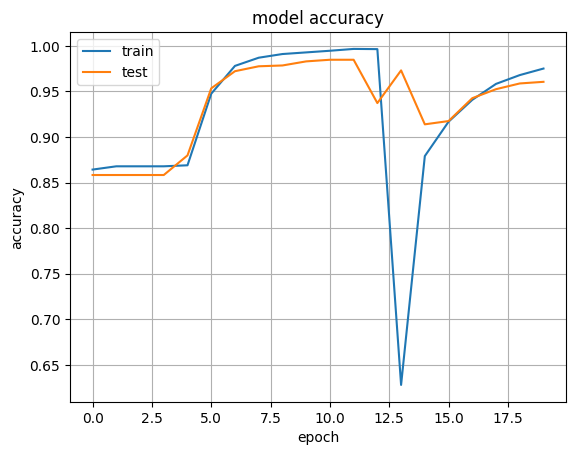

In [62]:
from  matplotlib import pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid()
plt.show()

In [63]:

from sklearn.metrics import confusion_matrix,f1_score, precision_score,recall_score

In [67]:
y_predict  = [1 if o>0.5 else 0 for o in model.predict(x_test_features)]
cf_matrix =confusion_matrix(test_y,y_predict)
tn, fp, fn, tp = confusion_matrix(test_y,y_predict).ravel()
print("Precision: {:.2f}%".format(100 * precision_score(test_y, y_predict)))
print("Recall: {:.2f}%".format(100 * recall_score(test_y, y_predict)))
print("F1 Score: {:.2f}%".format(100 * f1_score(test_y,y_predict)))

35/35 [==============================] - 20s 537ms/step
Precision: 98.31%
Recall: 73.42%
F1 Score: 84.06%


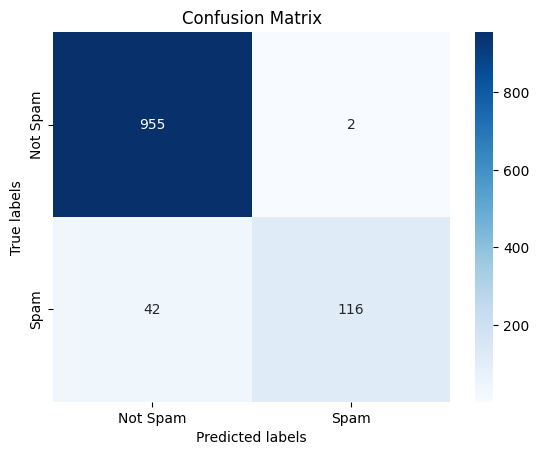

In [68]:
import seaborn as sns
import matplotlib.pyplot as plt

ax= plt.subplot()
sns.heatmap(cf_matrix, annot=True, ax = ax,cmap='Blues',fmt=''); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(['Not Spam', 'Spam']); ax.yaxis.set_ticklabels(['Not Spam', 'Spam']);

In [69]:
f1_score(test_y,y_predict)

0.8405797101449277